In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats as stat
#from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
(7, 100, 64)
[ 1  1 -1 ...  1  1 -1]
(7, 5000)
46
[[0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
  0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0
  0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1]
 [1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0
  0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0
  1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1]
 [1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1
  0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0
  0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1]
 [1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1
  0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1

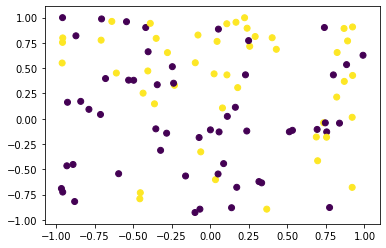

In [2]:
distorts = [
            lambda eta: eta, 
#             lambda eta:0.3+0.4*eta,
            lambda eta:stat.beta.cdf(eta,0.2,0.2),
            lambda eta:stat.beta.cdf(eta,5.,5.),
            lambda eta:stat.beta.cdf(eta,0.5,2),
            lambda eta:stat.beta.cdf(eta,2,0.5),
            lambda eta:stat.beta.cdf(eta,20,80)*0.25 +
                       stat.beta.cdf(eta,80,20)*0.25 + 
                       stat.beta.cdf(eta,0.1,0.1)*0.5,
            lambda eta:stat.beta.cdf(eta,30,10)*0.5 +
                       stat.beta.cdf(eta,0.1,0.1)*0.5
           ]

num_annots = len(distorts)

num_dp_per_annot = 100
num_test = 5000
data_dim = 64
w_star = 2.*np.ones((data_dim))
print(w_star)
np.random.seed(100)
x_all_train = 2*np.random.rand(num_annots, num_dp_per_annot, data_dim)-1
eta_all_train = 1./(1+np.exp(-np.dot(x_all_train,w_star)))
y_all_train = 2*(np.random.rand(*eta_all_train.shape)<eta_all_train) - 1
print(x_all_train.shape)
x_all_test = 2*np.random.rand(num_test, data_dim)-1
eta_all_test = 1./(1+np.exp(-np.dot(x_all_test,w_star)))
y_all_test = 2*(np.random.rand(*eta_all_test.shape)<eta_all_test) - 1

print(y_all_test)
eta_tilde_all_train = np.array([distorts[i](eta_all_train[i]) for i in range(num_annots)])
y_tilde_all_train = 2*(np.random.rand(*eta_tilde_all_train.shape)<eta_tilde_all_train) - 1

eta_tilde_all_test = np.array([distorts[i](eta_all_test) for i in range(num_annots)])
y_tilde_all_test = 2*(np.random.rand(*eta_tilde_all_test.shape)<eta_tilde_all_test) - 1
print(y_tilde_all_test.shape)

j=0
plt.scatter(x_all_train[j][:,0], x_all_train[j][:,1], c= y_all_train[j])

print(np.sum(y_all_train[j]==+1))
X_train_d = x_all_train
Y_train_d = y_tilde_all_train
Y_train_d = (Y_train_d + 1)//2
X_test_d = []
for i in range(num_annots):
    X_test_d.append(x_all_test)
X_test_d = np.array(X_test_d)
Y_test_d = y_tilde_all_test
Y_test_d = (Y_test_d + 1)//2
print(Y_train_d)
print(Y_test_d)
#print(X_train_d[1])

In [9]:
def accuracy_score(Y, Y_pred):
    """Function to calculate loss (Y_test[i] - Y_pred[i])**2
       Y : 0 or 1 (labels)
       Y_pred: 0 to 1(probablities)"""
    loss = 0.0
    for i in range(Y.shape[0]):
        #print((Y[i] - Y_pred[i])**2)
        loss = loss + ((Y[i] - Y_pred[i])**2)
        
        
    #print(Y.shape[0])
    return loss/(Y.shape[0])
        

In [10]:
#Baseline-1 -- separate Logistic Regression for all labellers
w_list = []
accuracy_list = []
for i in range(num_annots):
   
    clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])  #training 
    Y_pred = clf.predict_proba(X_test_d[i])[:,1]    # predicting eta(x) = P(1|x) for training samples
    w_list.append(clf)
    #print(Y_pred)
    #print(Y_test_d[i])
    #print(Y_pred)
    accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))   # calculating accuracy
accuracy_list
#Y_test_distort[0].shape

[0.1697665130211012,
 0.1943933321638101,
 0.12474420695913564,
 0.13092115042736857,
 0.15551269124871522,
 0.24550069810582423,
 0.21852051087087435]

In [11]:
def sort(A,A_sum,labellers):
    for i in range(labellers):
        for j in range(len(A[i])):
            min_index = j
            for k in range(j,len(A[i])):
                if(A_sum[k] < A_sum[min_index]):
                    min_index = k
            A[i][j],A[i][min_index] =  A[i][min_index],A[i][j]
                    

In [12]:
samples = 100    #no. of samples to be taken for creating the post-processing model
random_indices = np.random.choice(5000,size = samples) 
#print(random_indices)
test_data = X_test_d[0][random_indices]   #take random feature vectors from test-data
#print(test_data)
A = []  #A indicates P(Y|X ) given by logistic regression for each labeller separately

# A[i][j] inidicates P(Y_ij = 1|X_j), prediction for the i_th labeller on test_data[j]
for i in range(num_annots):
    eta = w_list[i].predict_proba(test_data)[:,1]
    A.append(eta)

A = np.array(A)
A_sum = np.sum(A,axis = 0)  
#A_sum is  a 1d array of size samples. A_sum[i] = A_sum[0][i] + A_sum[1][i] + .... + A_sum[#labellers-1][i]
sort(A,A_sum,num_annots)
A_sum = np.sort(A_sum)
#print("-------")
#print(A_sum)
#print(A)
u = list(range(num_annots)) # u is prediction after monotonic regression
for i in range(num_annots):
    iso =  IsotonicRegression(out_of_bounds = 'clip').fit(A_sum,A[i])
    u[i] = iso.predict(A_sum)


u = np.array(u)
u.shape
#print(u)


(7, 100)

In [13]:
def project(a,b,c):     #a is target, b and c are points on the line
    """ Projection of point 'a' on to the line joining the points 'b' and 'c' """
    v = a - b 
    #print(v)
    d = (c-b)/np.linalg.norm(c-b)
    #print(np.linalg.norm(d))
    #print(d)
    res = b + (np.dot(v,d))*d
    return res

In [14]:
post_process_loss = list(range(num_annots))
Y_prob_pred = list(range(num_annots))
eta_hat = list(range(num_annots))    #logistic regression prediction for all the labellers
for i in range(num_annots):
    eta_hat[i] = w_list[i].predict_proba(X_test_d[i])[:,1]
eta_hat = np.array(eta_hat)
print(eta_hat)
print("_____________")
for i in range(num_annots):   # for each labeller
    temp_prob = []
    for j in range(len(X_test_d[i])): 
        distance = float("inf")
        projection = None
        for k in range(samples-1):
            if(np.array_equal(u[:,k],u[:,k+1])):
                continue
            current_projection = project(eta_hat[:,j],u[:,k],u[:,k+1])  
            #projection of eta_hat of current test vector on to the line joining points u[k] an u[k+1]
            if(np.linalg.norm(current_projection - eta_hat[:,j]) <= distance): 
                distance = np.linalg.norm(current_projection - eta_hat[:,j])
                projection = current_projection     
        temp_prob.append(projection[i])
        
    Y_prob_pred[i] = np.array(temp_prob)
    post_process_loss[i] = accuracy_score(Y_test_d[i],Y_prob_pred[i])
    
print(Y_prob_pred)  
print("____________________")
print(post_process_loss)
    
        
        

[[0.99660832 0.35199196 0.24711155 ... 0.2900035  0.85480785 0.91872639]
 [0.9947056  0.98843652 0.14788831 ... 0.43739086 0.95816078 0.04660508]
 [0.99872229 0.89901596 0.10841067 ... 0.77537424 0.89805205 0.53015523]
 ...
 [0.95297782 0.92561725 0.2199644  ... 0.44934466 0.9683209  0.06770053]
 [0.9910521  0.74727712 0.74739075 ... 0.73330898 0.60256922 0.0102834 ]
 [0.98796325 0.97011071 0.00301711 ... 0.02623384 0.71917519 0.00825282]]
_____________
[array([0.99204589, 0.5435273 , 0.11066328, ..., 0.41290811, 0.69984284,
       0.46092968]), array([0.98517873, 0.86777122, 0.12715829, ..., 0.51953619, 0.9493654 ,
       0.06758387]), array([0.83103114, 0.83103114, 0.50459139, ..., 0.79314124, 0.83103114,
       0.20202338]), array([0.98912513, 0.98912513, 0.45649349, ..., 0.65292088, 1.00458986,
       0.52569452]), array([0.70271512, 0.70271512, 0.41440734, ..., 0.41440734, 0.70271512,
       0.49844767]), array([0.9971413 , 0.64351382, 0.58187722, ..., 0.6329714 , 0.76675837,
    

In [24]:
iso = IsotonicRegression(out_of_bounds = 'clip').fit(np.array([1,2,3,4,5]),np.array([10,20,30,40,50])) 
iso.predict(np.array([10,20,30,40,50]))

array([50., 50., 50., 50., 50.])

In [37]:
A = np.array([[0,0.2,0.4,0.6,1],[0,0.2,0.8,0.4,1]])
A_sum = np.sum(A,axis = 0)  
#A_sum is  a 1d array of size samples. A_sum[i] = A_sum[0][i] + A_sum[1][i] + .... + A_sum[#labellers-1][i]
print(A)
sort(A,A_sum,2)
#print(A_sum)
print(A)
u = [0,0,0,0] # u is prediction after monotonic regression
for i in range(2):
    iso =  IsotonicRegression(out_of_bounds = 'clip').fit(np.array([1,2,3,4,5]),A[i])
    u[i] = iso.predict(np.array([1,2,3,4,5]))


u = np.array(u)
u.shape
print(u)


[[0.  0.2 0.4 0.6 1. ]
 [0.  0.2 0.8 0.4 1. ]]
[[0.  0.2 0.6 0.4 1. ]
 [0.  0.2 0.4 0.8 1. ]]
[array([0. , 0.2, 0.5, 0.5, 1. ]) array([0. , 0.2, 0.4, 0.8, 1. ]) 0 0]
